In [1]:
import jax
import tensorflow as tf
import ml_collections
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import torch

from pytorch3d.renderer import (PointLights, MeshRenderer,
                                RasterizationSettings, MeshRasterizer,
                                SoftPhongShader, Textures, PerspectiveCameras)

from pytorch3d.structures import Meshes
from PIL import Image
from pytorch3d.io import load_objs_as_meshes, load_obj
import time
from tqdm import tqdm
tf.config.set_visible_devices([], 'GPU')


2023-05-19 11:08:26.304131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/extras/CUPTI/lib64
2023-05-19 11:08:26.304431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/extras/CUPTI/lib64
2023-05-19 11:08:26.304434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
IMAGE_WIDTH  = 334
IMAGE_HEIGHT = 512

# IMAGE_WIDTH_RESIZE = 240
# IMAGE_HEIGHT_RESIZE = 320

NUM_VERTEX = 7306

In [3]:
config = ml_collections.ConfigDict()
config.model = 'Classic_CNN'
config.dataset = 'multiface'
config.image_size = (334, 512)
config.num_epochs = 200
config.warmup_epochs = 10
config.batch_size = 1
config.learning_rate = 0.0001
config.log_every_steps = 1
config.vertex = 7306
config.num_train_steps = -1

In [9]:
def readTFRECORD(tfrecord_pth: str,
                 config: ml_collections.ConfigDict) -> tf.data:
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    data_set = tf.data.TFRecordDataset(tfrecord_pth)
    # data_set = data_set.repeat()
    data_set = data_set.map(parse, num_parallel_calls=AUTOTUNE)

    # data_set = data_set.shuffle(config.batch_size * 16,
    #                             reshuffle_each_iteration=True)
    data_batch = data_set.batch(config.batch_size, drop_remainder=True)
    data_batch = data_batch.prefetch(buffer_size=AUTOTUNE)
    return data_batch


def parse(example_proto):
    features = tf.io.parse_single_example(example_proto,
                                          features={
                                              'img':
                                              tf.io.FixedLenFeature([],
                                                                    tf.string),
                                              'vtx':
                                              tf.io.FixedLenFeature([],
                                                                    tf.string),
                                            #   'vtx_mean':
                                            #   tf.io.FixedLenFeature([],
                                            #                         tf.string),
                                              # 'texture':
                                              # tf.io.FixedLenFeature([],
                                              #                       tf.string),
                                              # 'verts_uvs':
                                              # tf.io.FixedLenFeature([],
                                              #                       tf.string),
                                              # 'faces_uvs':
                                              # tf.io.FixedLenFeature([],
                                              #                       tf.string),
                                              # 'verts_idx':
                                              # tf.io.FixedLenFeature([],
                                              #                       tf.string),
                                              # 'head_pose':
                                              # tf.io.FixedLenFeature([],
                                              #                       tf.string),
                                            #   'intricsic_camera':
                                            #   tf.io.FixedLenFeature([],
                                            #                         tf.string),
                                            #   'extrinsic_camera':
                                            #   tf.io.FixedLenFeature([],
                                            #                         tf.string),
                                          })

    img = features['img']
    vtx = features['vtx']
    # vtx_mean = features['vtx_mean']
    # tex = features['texture']
    # verts_uvs = features['verts_uvs']
    # faces_uvs = features['faces_uvs']
    # verts_idx = features['verts_idx']
    # head_pose = features['head_pose']
    # intricsic_camera = features['intricsic_camera']
    # extrinsic_camera = features['extrinsic_camera']

    img = tf.io.decode_raw(img, tf.uint8)
    img = tf.cast(img, tf.float32)
    vtx = tf.io.decode_raw(vtx, np.float32)
    # vtx_mean = tf.io.decode_raw(vtx_mean, np.float32)
    # tex = tf.io.decode_raw(tex, np.float32)
    # verts_uvs = tf.io.decode_raw(verts_uvs, np.float32)
    # faces_uvs = tf.io.decode_raw(faces_uvs, np.float32)
    # verts_idx = tf.io.decode_raw(verts_idx, np.float32)
    # head_pose = tf.io.decode_raw(head_pose, np.float32)
    # intricsic_camera = tf.io.decode_raw(intricsic_camera, np.float32)
    # extrinsic_camera = tf.io.decode_raw(extrinsic_camera, np.float32)
    
    
    img = tf.reshape(img, [IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    # tex = tf.reshape(tex, [1024, 1024, 3])
    vtx = tf.reshape(vtx, [NUM_VERTEX, 3])
    # vtx_mean = tf.reshape(vtx_mean, [NUM_VERTEX, 3])
    # verts_uvs = tf.reshape(verts_uvs, [-1, 2])
    # faces_uvs = tf.reshape(faces_uvs, [-1, 3])
    # verts_idx = tf.reshape(verts_idx, [-1, 3])
    # head_pose = tf.reshape(head_pose, [3, 4])
    # intricsic_camera = tf.reshape(intricsic_camera, [3, 3])
    # extrinsic_camera = tf.reshape(extrinsic_camera, [3, 4])
    # focal = tf.constant([intricsic_camera[0, 0], intricsic_camera[1, 1]])
    # princpt = tf.constant([intricsic_camera[0, 0], intricsic_camera[1, 1]])
    # focal = np.array([intricsic_camera.numpy()[0, 0], intricsic_camera.numpy()[1, 1]])
    
    
    
    
    return {
      'img': img, 
            'vtx': vtx,
            # 'tex':tex, 
            # 'verts_uvs':verts_uvs, 
            # 'faces_uvs':faces_uvs, 
            # 'verts_idx':verts_idx,
            # 'head_pose':head_pose, 
            # 'vtx_mean':vtx_mean,'in_cam':intricsic_camera, 'ex_cam':extrinsic_camera
            }

In [17]:
ds = readTFRECORD('../training_data/test.tfrecord', config)

In [29]:
# 開始計時
start_time = time.time()
# 初始化計數器
step_count = 0
images = []
vtxes = []
for i, batch in enumerate(ds):
    vtxes.append(batch['vtx'].numpy().reshape((7306*3)))
    # for np_img in batch['img'].numpy():
    #     np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY).reshape((512, 334, 1))
    #     images.append(np_img)
vtxes = np.array(vtxes)
# np_images = np.array(images)
# print(np_images.shape)
# print(np.mean(np_images))
# print(np.std(np_images))

    

In [41]:
vtxes[0]

array([ -69.9181,  -23.5175,  -63.26  , ...,   25.4284,  -80.5315,
       -157.199 ], dtype=float32)

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=160)
pca.fit(vtxes)

PCA(n_components=160)

In [43]:
print(pca.components_)

[[-2.4891886e-04 -1.3048252e-03  2.0743322e-03 ... -6.8085146e-04
  -4.2556338e-03 -5.2008394e-04]
 [ 8.5981138e-04 -1.1439698e-03  1.0165412e-03 ... -6.3564780e-04
   4.1083694e-03 -4.9958676e-03]
 [ 1.1579241e-03 -2.1485528e-03  8.4615825e-04 ... -4.9534941e-04
   1.2681948e-03 -1.0834193e-03]
 ...
 [-2.2040075e-03 -2.1008279e-03 -6.2496345e-03 ...  3.9011408e-03
   6.2420662e-03 -1.9150902e-02]
 [ 2.2709765e-03  3.4356518e-03 -2.1662314e-03 ... -2.3711802e-02
   1.2608884e-02  1.8702690e-02]
 [ 6.2515272e-04  7.6887976e-05 -7.2012790e-03 ...  4.1125971e-03
  -1.8693533e-03 -2.3312455e-02]]


In [28]:
import torch
from tfrecord.torch.dataset import TFRecordDataset
tfrecord_path = "../training_data/full_6674443_240x320_43608_landmark.tfrecord"
import cv2
import numpy as np


def decode_image(features):
    # get BGR image from bytes

    features["img"] = np.frombuffer(features["img"], dtype=np.float32).reshape(
        (320, 240, 3)).copy()

    features["vtx"] = np.frombuffer(features["vtx"], dtype=np.float32).reshape(
        (7306, 3)).copy()

    # features["vtx_mean"] = np.frombuffer(features["vtx_mean"],
    #                                      dtype=np.float32).reshape(
    #                                          (7306, 3)).copy()

    # features["tex"] = np.frombuffer(features["tex"], dtype=np.float32).reshape(
    #     (1024, 1024, 3)).copy() / 255.
    # features["verts_uvs"] = np.frombuffer(features["verts_uvs"],
    #                                       dtype=np.float32).reshape(
    #                                           (-1, 2)).copy()
    # features["faces_uvs"] = np.frombuffer(features["faces_uvs"],
    #                                       dtype=np.float32).reshape(
    #                                           (-1, 3)).copy()
    # features["verts_idx"] = np.frombuffer(features["verts_idx"],
    #                                       dtype=np.float32).reshape(
    #                                           (10936, 3)).copy(),
    # features["head_pose"] = np.frombuffer(features["head_pose"],
    #                                       dtype=np.float32).reshape(
    #                                           (3, 4)).copy()

    # features["intricsic_camera"] = np.frombuffer(features["intricsic_camera"],
    #                                              dtype=np.float32).reshape(
    #                                                  (3, 3)).copy()
    # features['focal'] = np.stack([
    #     features["intricsic_camera"][0, 0], features["intricsic_camera"][1, 1]
    # ], )

    # features['princpt'] = np.stack([
    #     features["intricsic_camera"][0, 2], features["intricsic_camera"][1, 2]
    # ], )
    # features["extrinsic_camera"] = np.frombuffer(features["extrinsic_camera"],
    #                                              dtype=np.float32).reshape(
    #                                                  (3, 4)).copy()

    return features


index_path = None
description = {
    "img": "byte",
    "vtx": "byte",
    # "vtx_mean": "byte",
    # "tex": "byte",
    # "verts_uvs": "byte",
    # "faces_uvs": "byte",
    # "verts_idx": "byte",
    # "head_pose": "byte",
    # "intricsic_camera": "byte",
    # "extrinsic_camera": "byte"
}
dataset = TFRecordDataset(tfrecord_path,
                          index_path,
                          description,
                          transform=decode_image)
ds = torch.utils.data.DataLoader(dataset, batch_size=32)

# for i, batch in enumerate(loader):
#     print(batch['faces_uvs'][0].shape)

#     # cv2.imwrite('testest.png', batch['tex'][0].numpy().astype('uint8'))
#     break


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class Renderer():

    def __init__(self, device: str = 'cuda:0'):
        self.device = device

    def _split_batch_to_list(self, tensor):
        # split the tensor along the first dimension
        tensor = torch.split(tensor, split_size_or_sections=1, dim=0)
        # # remove the first dimension from each tensor in the list
        tensor = [t.squeeze(0).to(self.device) for t in tensor]
        return tensor
    
    def _linear_transform(self, verts, transform):
        """
            對一個 batch 的頂點進行線性轉換
            Args:
                verts: shape (batch_size, num_verts, 3) 的頂點坐標張量
                transform: shape (batch_size, 3, 4) 的線性轉換矩陣張量
            Returns:
                shape (batch_size, num_verts, 3) 的轉換後的頂點坐標張量
        """
        batch_size, num_verts, _ = verts.shape
        R = transform[:, :3, :3]
        t = transform[:, :, 3].unsqueeze(1)
        verts = torch.bmm(R, verts.transpose(1, 2)).transpose(1, 2) + t
        return verts

    def render(self, verts, faces_uvs, verts_uvs, verts_idx, texture_image, transform_head,
               transform_camera, focal, princpt, render_width, render_height):

        # verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
        # faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)
        
        tex = Textures(verts_uvs=verts_uvs,
                       faces_uvs=faces_uvs,
                       maps=texture_image)

        verts_head = self._linear_transform(verts, transform_head)
        verts_cam = self._linear_transform(verts_head, transform_camera)

        meshes = Meshes(verts=self._split_batch_to_list(verts_cam),
                        faces=self._split_batch_to_list(verts_idx),
                        textures=tex.to(self.device))

        cameras = PerspectiveCameras(device=self.device,
                                     focal_length=-focal,
                                     principal_point=princpt,
                                     in_ndc=False,
                                     image_size=((2048,
                                                  1334), ))

        raster_settings = RasterizationSettings(
            image_size=[render_height, render_width],
            blur_radius=0.0,
            faces_per_pixel=1,
        )

        lights = PointLights(device=self.device, location=[[0.0, 1.0, -10.0]])

        with torch.no_grad():
            renderer = MeshRenderer(rasterizer=MeshRasterizer(
                cameras=cameras, raster_settings=raster_settings),
                                    shader=SoftPhongShader(device=self.device,
                                                           cameras=cameras,
                                                           lights=lights))
            images = renderer(meshes, znear=0.0, zfar=1500.0)

        return images
rend = Renderer()

In [ ]:

import numpy as np
import cv2

def decode_image(features):
    # get BGR image from bytes

    features["img"] = np.frombuffer(features["img"], dtype=np.float32).reshape(
        (512, 334, 3)).copy()
    # features["img"] = cv2.cvtColor(features["img"] , cv2.COLOR_BGR2RGB)
    features["vtx"] = np.frombuffer(features["vtx"], dtype=np.float32).reshape(
        (7306, 3)).copy()

    features["vtx_mean"] = np.frombuffer(features["vtx_mean"],
                                         dtype=np.float32).reshape(
                                             (7306, 3)).copy()

    features["tex"] = np.frombuffer(features["tex"], dtype=np.float32).reshape(
        (1024, 1024, 3)).copy() / 255.
    features["verts_uvs"] = np.frombuffer(features["verts_uvs"],
                                          dtype=np.float32).reshape(
                                              (-1, 2)).copy()
    features["faces_uvs"] = np.frombuffer(features["faces_uvs"],
                                          dtype=np.float32).reshape(
                                              (-1, 3)).copy()
    features["verts_idx"] = np.frombuffer(features["verts_idx"],
                                          dtype=np.float32).reshape(
                                              (-1, 3)).copy(),
    features["head_pose"] = np.frombuffer(features["head_pose"],
                                          dtype=np.float32).reshape(
                                              (3, 4)).copy()

    features["intricsic_camera"] = np.frombuffer(features["intricsic_camera"],
                                                 dtype=np.float32).reshape(
                                                     (3, 3)).copy()

    features['focal'] = np.stack([
        features["intricsic_camera"][0, 0], features["intricsic_camera"][1, 1]
    ], )

    features['princpt'] = np.stack([
        features["intricsic_camera"][0, 2], features["intricsic_camera"][1, 2]
    ], )
    features["extrinsic_camera"] = np.frombuffer(features["extrinsic_camera"],
                                                 dtype=np.float32).reshape(
                                                     (3, 4)).copy()
    return features

dataset = TFRecordDataset(tfrecord_path,
                            index_path,
                            description,
                            transform=decode_image,
                            shuffle_queue_size=1024)
loader = torch.utils.data.DataLoader(dataset, batch_size=32)


In [10]:
# 開始計時
start_time = time.time()
# 初始化計數器
step_count = 0
for i, batch in enumerate(ds):
    step_count += 1
    if time.time() - start_time > 1.:
        print("即時每秒執行的步驟數：", step_count)
        step_count = 0
        start_time = time.time()
    # img = batch["img"].to(device)
    # vtx = batch['vtx'].to(device)
    # vtx_mean = batch['vtx_mean'].to(device)
    # tex = batch['tex'].to(device)
    # verts_uvs = batch['verts_uvs'].to(device)
    # faces_uvs = batch['faces_uvs'].to(device, dtype=torch.int64)
    # verts_idx = batch['verts_idx'][0].to(device, dtype=torch.int64)
    # head_pose = batch['head_pose'].to(device)
    # focal = batch['focal'].to(device)
    # princpt = batch['princpt'].to(device)
    # extrinsic_camera = batch['extrinsic_camera'].to(device)
    
    # images = rend.render(vtx,faces_uvs, verts_uvs, verts_idx, tex, head_pose,extrinsic_camera, focal, princpt, 334, 512)
    # break

即時每秒執行的步驟數： 29


In [10]:
n = 0
for step, batch in enumerate(ds):
    start = time.time()
    in_cam = batch['in_cam'].numpy()
    focal = torch.Tensor(np.array([in_cam[:, 0, 0], in_cam[:, 1, 1]]).T)
    princpt = torch.Tensor(np.array([in_cam[:, 0, 2], in_cam[:, 1, 2]]).T)
    
    verts = torch.Tensor(batch['vtx'].numpy())
    head_pose = torch.Tensor(batch['head_pose'].numpy())
    ex_cam = torch.Tensor(batch['ex_cam'].numpy())
    verts_uvs = torch.Tensor(batch['verts_uvs'].numpy())
    faces_uvs = torch.Tensor(batch['faces_uvs'].numpy()).to(dtype=torch.int64)
    verts_idx = torch.tensor(batch['verts_idx'].numpy()).to(dtype=torch.int64)
    texture_image = torch.Tensor(batch['tex'].numpy()) / 255.0
    # texture_image = torch.flip(texture_image, dims=[1])
    
    images = rend.render(verts, faces_uvs, verts_uvs, verts_idx,texture_image, head_pose, 
                ex_cam, focal, princpt, 334, 512)
    raw = batch['img'].numpy()
    print(time.time()-start)
    break

0.02020406723022461


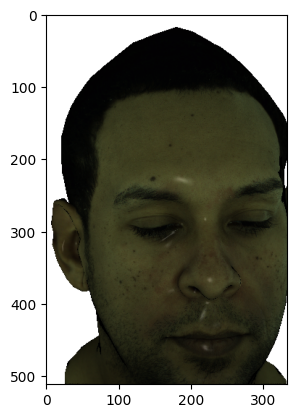

In [14]:
img = 255*images[0].cpu().contiguous().numpy()
img = img.astype('uint8')
img = img[:, :, :3]
cv2.imwrite('../test_data/test1.png',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# img = cv2.rotate(img, cv2.ROTATE_180)
plt.imshow(img)

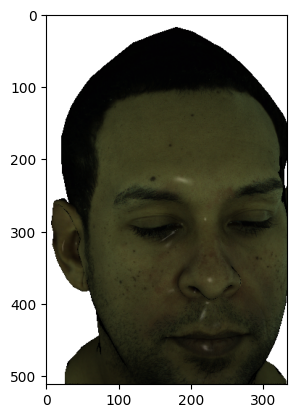

In [ ]:
img = 255*images[0].cpu().contiguous().numpy()
img = img.astype('uint8')
img = img[:, :, :3]
cv2.imwrite('../test_data/test1.png',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# img = cv2.rotate(img, cv2.ROTATE_180)
plt.imshow(img)

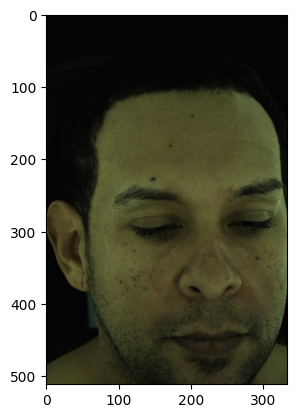

In [12]:
img = raw[0].astype('uint8')
# img = img.astype('uint8')
# img = img[:, :, :3]
cv2.imwrite('../test_data/test2.png',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# img = cv2.rotate(img, cv2.ROTATE_180)
plt.imshow(img)

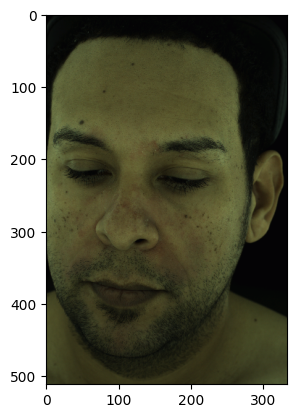

In [5]:
img = cv2.imread('/home/aaron/Desktop/multiface/6674443_GHS/images/E001_Neutral_Eyes_Open/400002/000220.png')
img = cv2.resize(img, (334, 512))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [19]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

class FaceMesh():
    
    def __init__(self):
        
        self.face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,
                                max_num_faces=1,
                                refine_landmarks=True,
                                min_detection_confidence=0.5)
    def detect(self, image):
        
        kpt = np.zeros((478, 2))
        
        # Convert the BGR image to RGB before processing.
        results = self.face_mesh.process(image)

        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
            return False, kpt
        
        annotated_image = image.copy()
        for face_landmarks in results.multi_face_landmarks:
            
            for idx, data_point in enumerate(face_landmarks.landmark):
                kpt[idx, 0] = data_point.x * annotated_image.shape[1]
                kpt[idx, 1] = data_point.y * annotated_image.shape[0]
        
        return True, kpt
    
face_detect = FaceMesh()

In [18]:
import numpy as np

# 读取二进制文件
with open('vert_var.txt', 'r') as f:
    # 读取数据
    vert_var = f.read()
    
# 读取二进制文件
with open('vert_mean.bin', 'rb') as f:
    # 读取数据
    data = f.read()

# 解析数据
vert_mean = np.frombuffer(data, dtype=np.float32)
# print(type(vert_var))
# # 解析数据
# vert_meanANDvar = {'vert_mean': vert_mean, 'vert_var': np.float32(vert_var)}
np.save('vert_mean.npy', vert_mean)
np.save('vert_var.npy', np.float32(vert_var))
# vert_var = np.frombuffer(data, dtype=np.float32)

# # 打印结果
# print(vert_var)


In [273]:
verts, faces_idx, _ = load_obj('../training_data/000220.obj')
# verts = (verts.reshape(7306*3, ) - vert_mean) / vert_var
# verts = verts.reshape(7306, 3)
transform = [0.9759047,0.004041422 ,0.21815981 ,-275.5805,
0.10419873 ,0.86982536 ,-0.4822307 ,456.9492,
-0.19170985 ,0.49334317 ,0.84844553 ,191.94185]

transform = [-0.6413242, 0.014517092, -0.76713264, 773.42,
-0.7567478, 0.15304689, 0.6355387, -645.5726,
0.12663344, 0.9881123, -0.0871669, 1268.4379]

transform = [9.962360262870788574e-01, 8.522809948772192001e-04, 8.667919784784317017e-02, 2.705120086669921875e+01,
2.758640050888061523e-02, -9.510800242424011230e-01, -3.077090084552764893e-01, 2.746159934997558594e+01,
8.217670023441314697e-02, 3.089419901371002197e-01, -9.475240111351013184e-01, 9.633099975585937500e+02]
transform = np.array(transform).reshape((3, 4))
R = transform[:3, :3]
t = transform[:, 3]
verts = ((R@verts.numpy().T).T + t)


In [5]:
a = [1,2,3,4,5]
a[:2]

[1, 2]

In [26]:
mesh = load_objs_as_meshes(['../training_data/000220.obj'])

verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)))

/home/aaron/miniconda3/envs/mp/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [3]:
mean_mesh_pth = '/home/aaron/Desktop/multiface/6674443_GHS/geom/vert_mean.bin'
with open(mean_mesh_pth, 'rb') as f:
    data = f.read()
    mesh_mean = torch.from_numpy(
        np.frombuffer(data, dtype=np.float32).reshape(
            (7306, 3)))

/tmp/ipykernel_77435/3044058483.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  mesh_mean = torch.from_numpy(


In [4]:
mesh_mean

tensor([[ -69.6198,  -23.5423,  -63.4862],
        [ -46.9879,  -75.7622,    7.1212],
        [ -23.8543,  -71.8140,   40.8626],
        ...,
        [  52.0039,  -82.6874, -139.8588],
        [  40.2287,  -80.5760, -149.9287],
        [  27.1954,  -80.3196, -158.7309]])

In [29]:
center = mesh_mean.mean(0)
scale = max((mesh_mean - center).abs().max(0)[0])



In [35]:
scale

tensor(193.9702)

In [32]:
mesh_mean *= (1.0 / float(scale))

In [33]:
mesh_mean

tensor([[-0.3589, -0.1214, -0.3273],
        [-0.2422, -0.3906,  0.0367],
        [-0.1230, -0.3702,  0.2107],
        ...,
        [ 0.2681, -0.4263, -0.7210],
        [ 0.2074, -0.4154, -0.7729],
        [ 0.1402, -0.4141, -0.8183]])

In [15]:
import torch
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform,
    TexturesUV,
    FoVPerspectiveCameras,
    PointLights,
    MeshRenderer,
    RasterizationSettings,
    MeshRasterizer,
    SoftPhongShader,
    BlendParams,
    Textures,
    PerspectiveCameras

)
import cv2
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes
from PIL import Image
from pytorch3d.io import load_objs_as_meshes, load_obj

device='cuda:0'    
verts, faces, aux = load_obj('../test_data/000220.obj')

with open('../training_data/000220.bin', 'rb') as f:
    # 读取数据
    data = f.read()

# 解析数据
verts = np.frombuffer(data, dtype=np.float32)
verts = verts.reshape((7306, 3))
verts = torch.Tensor(verts.copy())



verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)

texture_image = Image.open("../test_data/000220.png")
texture_image = texture_image.transpose(Image.FLIP_TOP_BOTTOM)
texture_image = np.array(texture_image)[::-1, :, :].copy()
texture_image = torch.from_numpy(texture_image).float() / 255.0
texture_image = texture_image.reshape((1, 1024, 1024, 3))

tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)

# transform world-coordinate to camera-coordinate
# transform = [-0.6413242, 0.014517092, -0.76713264, 773.42,
# -0.7567478, 0.15304689, 0.6355387, -645.5726,
# 0.12663344, 0.9881123, -0.0871669, 1268.4379]


transform_head = [9.962360262870788574e-01, 8.522809948772192001e-04, 8.667919784784317017e-02, 2.705120086669921875e+01,
2.758640050888061523e-02, -9.510800242424011230e-01, -3.077090084552764893e-01, 2.746159934997558594e+01,
8.217670023441314697e-02, 3.089419901371002197e-01, -9.475240111351013184e-01, 9.633099975585937500e+02]

transform_camera = [0.9759047, 0.004041422, 0.21815981, -275.5805,
0.10419873, 0.86982536, -0.4822307, 456.9492,
-0.19170985, 0.49334317, 0.84844553, 191.94185]


transform = np.array(transform_head).reshape((3, 4))
R = transform[:3, :3]
t = transform[:, 3]
verts = torch.tensor(((R@verts.numpy().T).T + t), dtype=torch.float32)

transform = np.array(transform_camera).reshape((3, 4))
R = transform[:3, :3]
t = transform[:, 3]
verts = torch.tensor(((R@verts.numpy().T).T + t), dtype=torch.float32)

# verts[:, 0] *= -1
# verts[:, 1] *= -1

# verts_ndc = get_ndc(verts, 0, 100)
# transform camera-coordinate to NDC-coordinate


# print(tex.shape)
meshes = Meshes(verts=[verts.to(device)], faces=[faces.verts_idx.to(device)], textures=tex.to(device))

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!

# verts = meshes.verts_packed()
# N = verts.shape[0]
# center = verts.mean(0)
# scale = max((verts - center).abs().max(0)[0])
# meshes.offset_verts_(-center)
# meshes.scale_verts_((1.0 / float(scale)))

# 設置攝像機和照明

focal = torch.tensor([7702.4736, 7703.745], dtype=torch.float32).to(device).unsqueeze(0)
princpt = torch.tensor([801.6277, 997.59296], dtype=torch.float32).to(device).unsqueeze(0)
print(focal.shape)
cameras = PerspectiveCameras(device=device, focal_length=-focal, principal_point=princpt, in_ndc=False, image_size=((2048, 1334),))
# cameras = PerspectiveCameras(device=device, focal_length=focal, principal_point=princpt)
raster_settings = RasterizationSettings(
            image_size=[320, 240],
            blur_radius=0.0,
            faces_per_pixel=1,
        )

lights = PointLights(device=device, location=[[0.0, 1.0, -10.0]])

with torch.no_grad():
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights
        )
    )
    images = renderer(meshes, znear=0.0, zfar=1500.0)



torch.Size([1, 2])


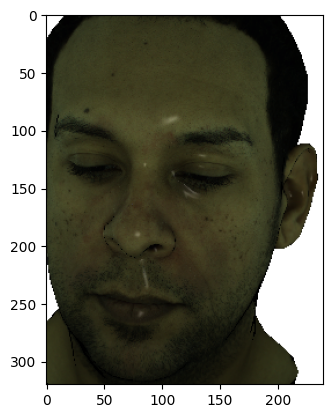

In [16]:
img = 255*images.cpu().contiguous().numpy()
img = img.astype('uint8')
img = img[0, :, :, :3]
cv2.imwrite('../test_data/test.png',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# img = cv2.rotate(img, cv2.ROTATE_180)
plt.imshow(img)


In [34]:
subject = '6674443'
facial = 'E001_Neutral_Eyes_Open'
view = '400008'
idx = '000220'

with open(
        f'/home/aaron/Desktop/multiface/{subject}_GHS/geom/tracked_mesh/{facial}/{idx}.obj',
        'r') as f:
    total_lines = len(f.readlines())

print(total_lines)
txt = ''
with open(
        f'/home/aaron/Desktop/multiface/{subject}_GHS/geom/tracked_mesh/{facial}/{idx}.obj',
        'r') as f:
    for i in range(7306):
        f.readline()
        txt += f'v {mesh_mean[i][0]} {mesh_mean[i][1]} {mesh_mean[i][2]}\n'
    for _ in range(7306, total_lines):

        txt += f.readline()

with open('../test_data/test.obj', 'w') as w:
    w.write(txt)

51050
